In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
organizations_zalando_research_fashionmnist_path = kagglehub.dataset_download('organizations/zalando-research/fashionmnist')

print('Data source import complete.')

In [ ]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.decomposition import PCA

# Load and process data

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist
data = fashion_mnist.load_data()
(X_train, y_train), (X_test, y_test) = data
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42, stratify = y_train)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


## Checking NaN values

In [ ]:
datasets = {
    "X_train": X_train,
    "y_train": y_train,
    "X_valid": X_valid,
    "y_valid": y_valid,
    "X_test": X_test,
    "y_test": y_test,
}

for name, dataset in datasets.items():
    nan_count = np.sum(np.isnan(dataset))
    if nan_count > 0:
        print(f"{nan_count} NaN values found in {name}")
    else:
        print(f"No NaN values found in {name}")

No NaN values found in X_train
No NaN values found in y_train
No NaN values found in X_valid
No NaN values found in y_valid
No NaN values found in X_test
No NaN values found in y_test


## Checking shape of data

In [ ]:
X_train.shape, y_train.shape,X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((48000, 28, 28),
 (48000,),
 (12000, 28, 28),
 (12000,),
 (10000, 28, 28),
 (10000,))

## Counting each label for each data split

In [ ]:
from collections import Counter
# Fashion MNIST class names
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]
def get_label_count(y_data):
    # Count the occurrences of each label in y_train
    label_counts = Counter(y_data)

    # Map the label numbers to their names
    label_name_counts = {class_names[label]: count for label, count in label_counts.items()}

    # Display the label counts
    for label, count in label_name_counts.items():
        print(f"{label}: {count}")
print("-----Training label count-----")
get_label_count(y_train)
print("-----Valid label count-----")
get_label_count(y_valid)
print("-----Test label count-----")
get_label_count(y_test)

-----Training label count-----
Shirt: 4800
Dress: 4800
T-shirt/top: 4800
Sandal: 4800
Ankle boot: 4800
Trouser: 4800
Sneaker: 4800
Bag: 4800
Coat: 4800
Pullover: 4800
-----Valid label count-----
Sandal: 1200
Coat: 1200
Pullover: 1200
Trouser: 1200
T-shirt/top: 1200
Dress: 1200
Shirt: 1200
Bag: 1200
Ankle boot: 1200
Sneaker: 1200
-----Test label count-----
Ankle boot: 1000
Pullover: 1000
Trouser: 1000
Shirt: 1000
Coat: 1000
Sandal: 1000
Sneaker: 1000
Dress: 1000
Bag: 1000
T-shirt/top: 1000


Visualize data images

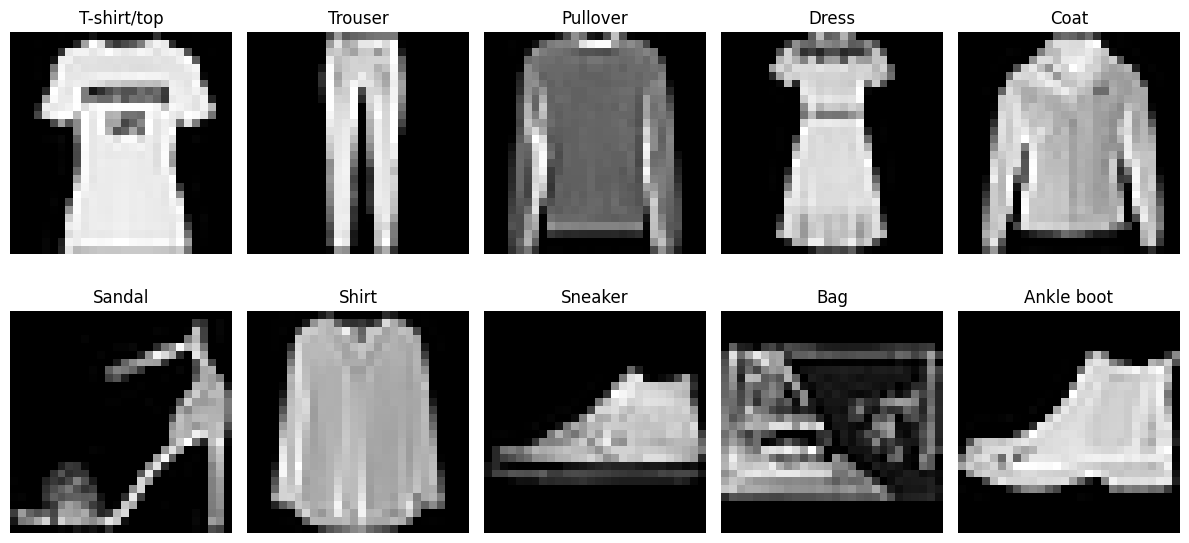

In [ ]:
# Create a grid of 2 rows and 5 columns to plot 10 images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.ravel()

# Plot one image for each category
for i in range(10):
    # Find the first image for the current class
    class_index = np.where(y_train == i)[0][0]
    image = X_train[class_index]

    # Display the image
    axes[i].imshow(image, cmap="gray")
    axes[i].set_title(class_names[i])
    axes[i].axis('off')

plt.tight_layout()
plt.savefig("each_category_img")
plt.show()

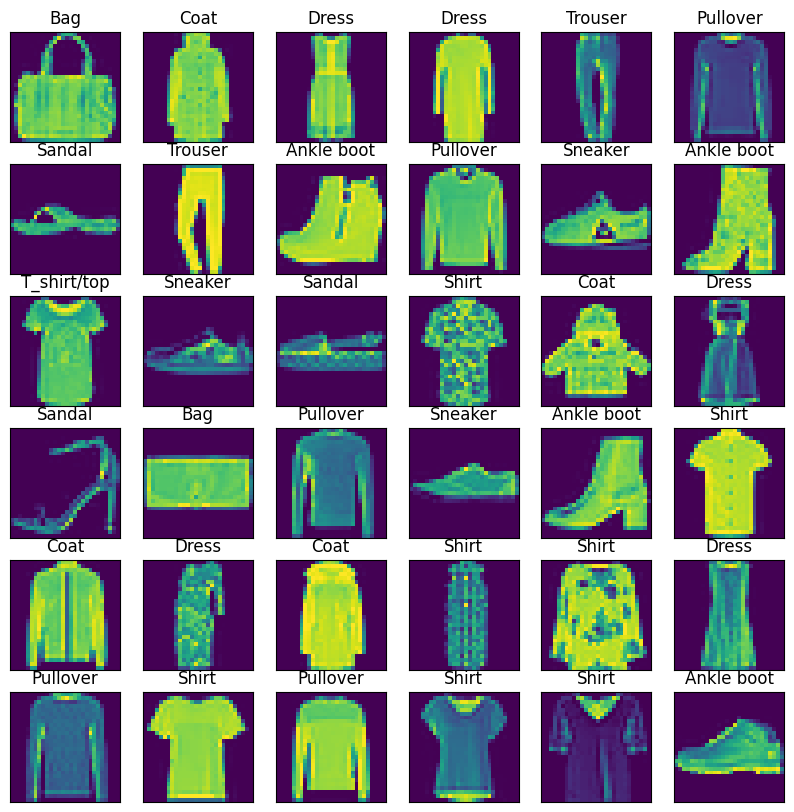

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(36):
    plt.subplot(6, 6, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i].reshape((28,28)))
    label_index = int(y_train[i])
    plt.title(class_names[label_index])
plt.show()

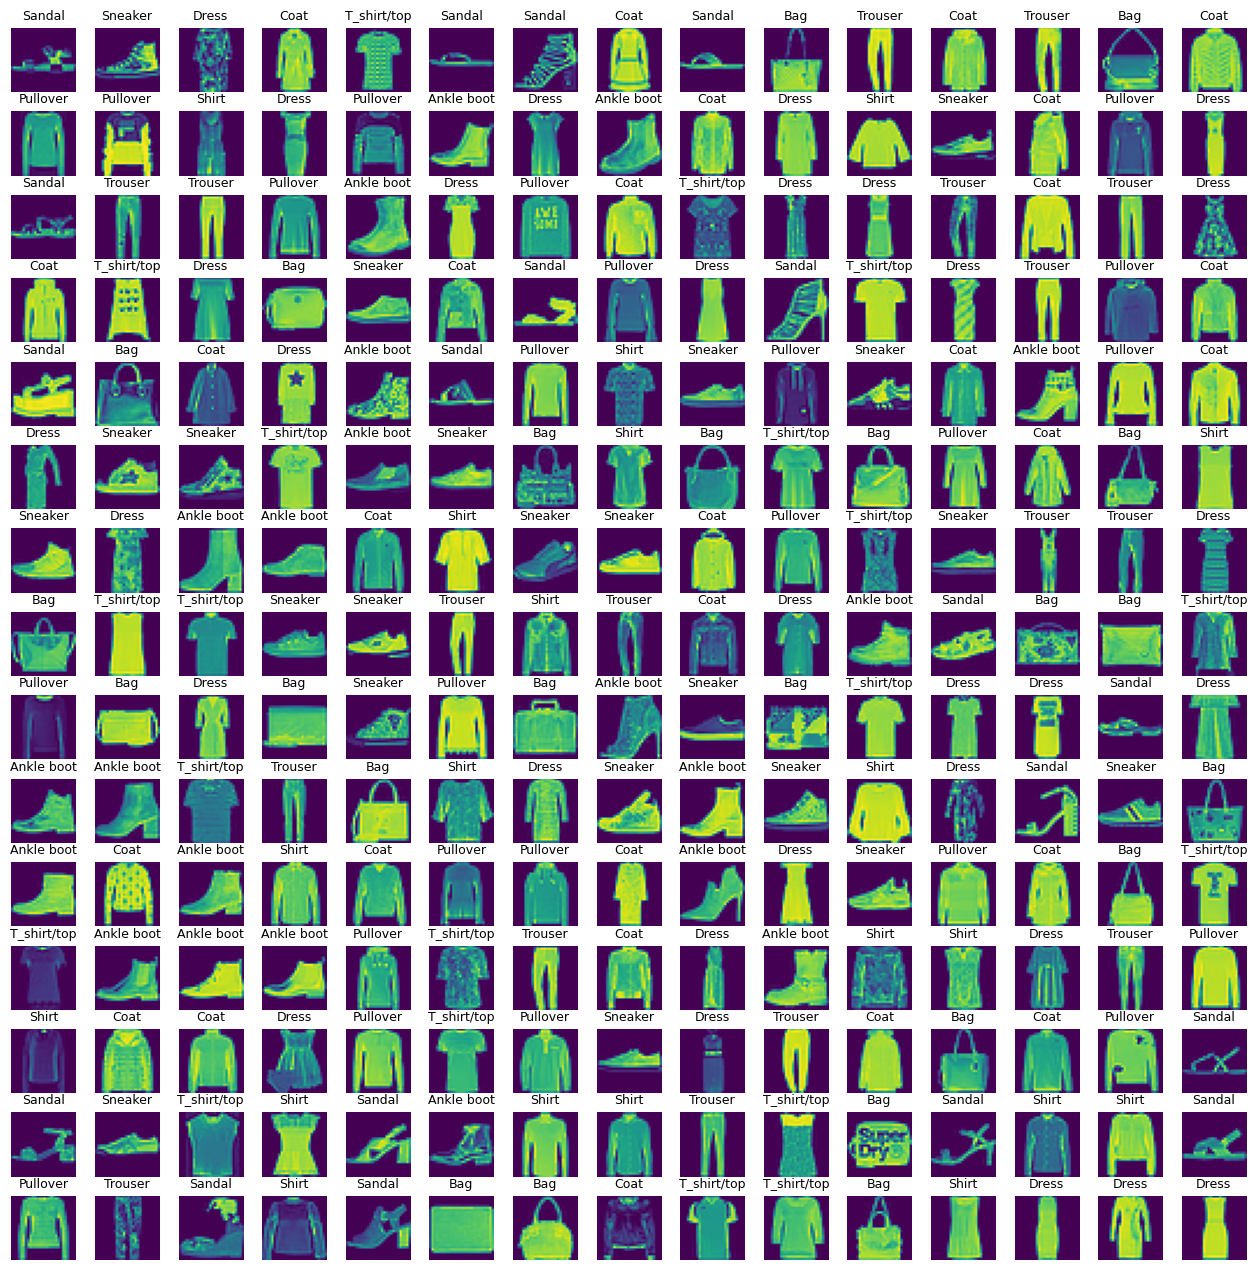

In [ ]:
W_grid = 15
L_grid = 15

fig, axes = plt.subplots(L_grid, W_grid, figsize = (16,16))
axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array
n_train = len(X_train) # get the length of the train dataset

# Select a random number from 0 to n_train
for i in np.arange(0, W_grid * L_grid): # create evenly spaces variables

    # Select a random number
    index = np.random.randint(0, n_train)
    # read and display an image with the selected index
    axes[i].imshow(X_train[index].reshape((28,28)) )
    labelindex = int(y_train[index])
    axes[i].set_title(class_names[labelindex], fontsize = 9)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.3)

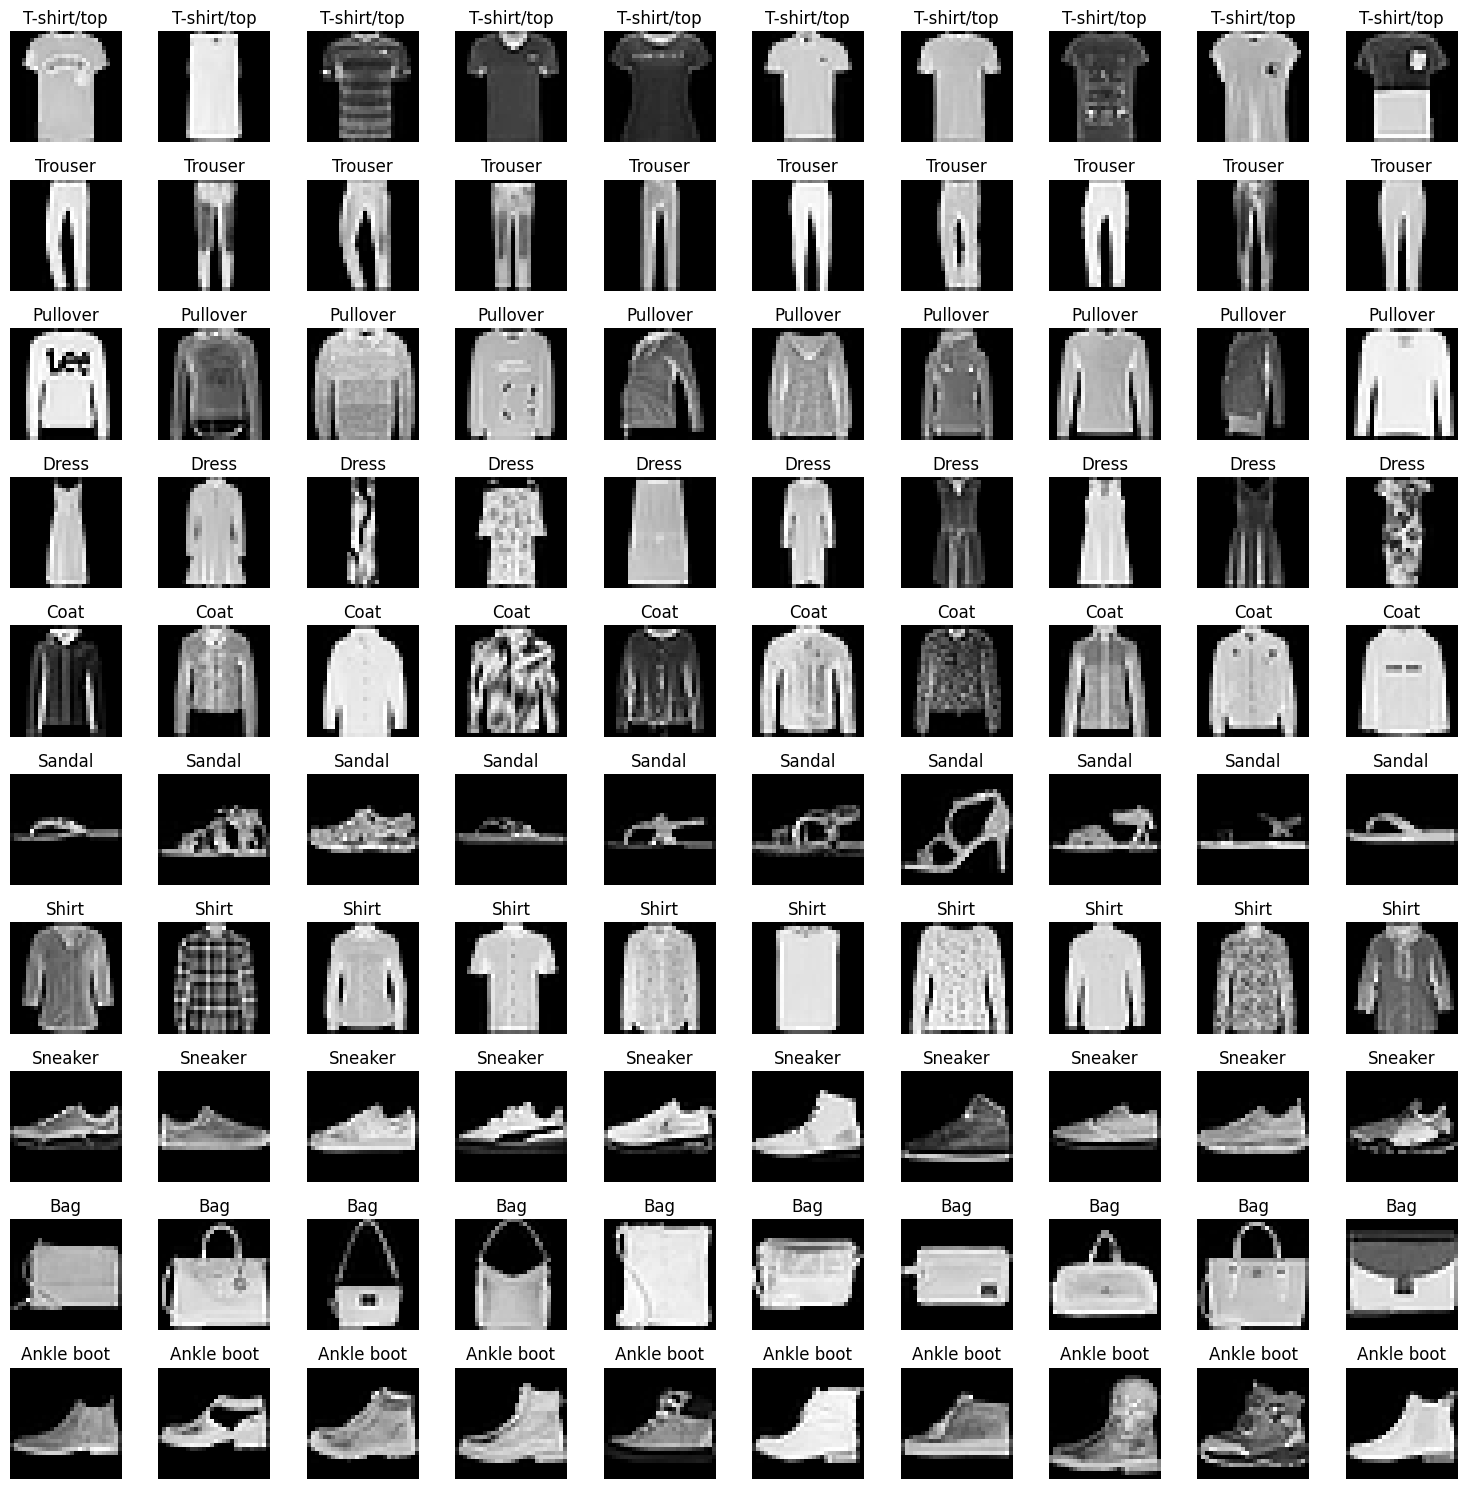

In [ ]:
# Plot 10 images for each class
num_images = 10  # Number of images to display per class
plt.figure(figsize=(15, 15))
for class_idx, class_name in enumerate(class_names):
    # Get indices of images belonging to the current class
    class_indices = np.where(y_test == class_idx)[0][:num_images]

    for i, index in enumerate(class_indices):
        plt.subplot(len(class_names), num_images, class_idx * num_images + i + 1)
        plt.imshow(X_test[index], cmap="gray")  # Display in grayscale
        plt.title(class_name)
        plt.axis("off")

plt.tight_layout()
plt.savefig("each_category_img")
plt.show()

Flatten the data

In [ ]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_valid_flat = X_valid.reshape(X_valid.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

In [ ]:
print(pd.DataFrame(X_train_flat).head())

   0    1    2    3    4    5    6    7    8    9    ...  774  775  776  777  \
0    0    0    0    0    1    1    0    0    0   25  ...   49    0    0    0   
1    0    0    0    0    0    0    0    0    1    0  ...  184  182  191   39   
2    0    0    0    0    0    0    0    0    0    0  ...    4    0    0    0   
3    0    0    0    0    0    0    0    0   11  106  ...  154   96    0    0   
4    0    0    0    0    0    0    1    0    0    0  ...  198  197  190  204   

   778  779  780  781  782  783  
0    0    0    0    0    0    0  
1    0    2    0    0    0    0  
2    0    0    0    0    0    0  
3    0    0    0    0    0    0  
4  115    0    0    0    0    0  

[5 rows x 784 columns]


# T-SNE

## Statistical information

In [ ]:
print(X_train_flat.shape)
print(X_train_flat.max())
print(X_train_flat.min())
print(X_train_flat.var())
print(X_train_flat.std())
print(X_train_flat.mean())

(48000, 784)
1.0
0.0
0.12473172
0.3531738
0.28625306


## Original Dimensions

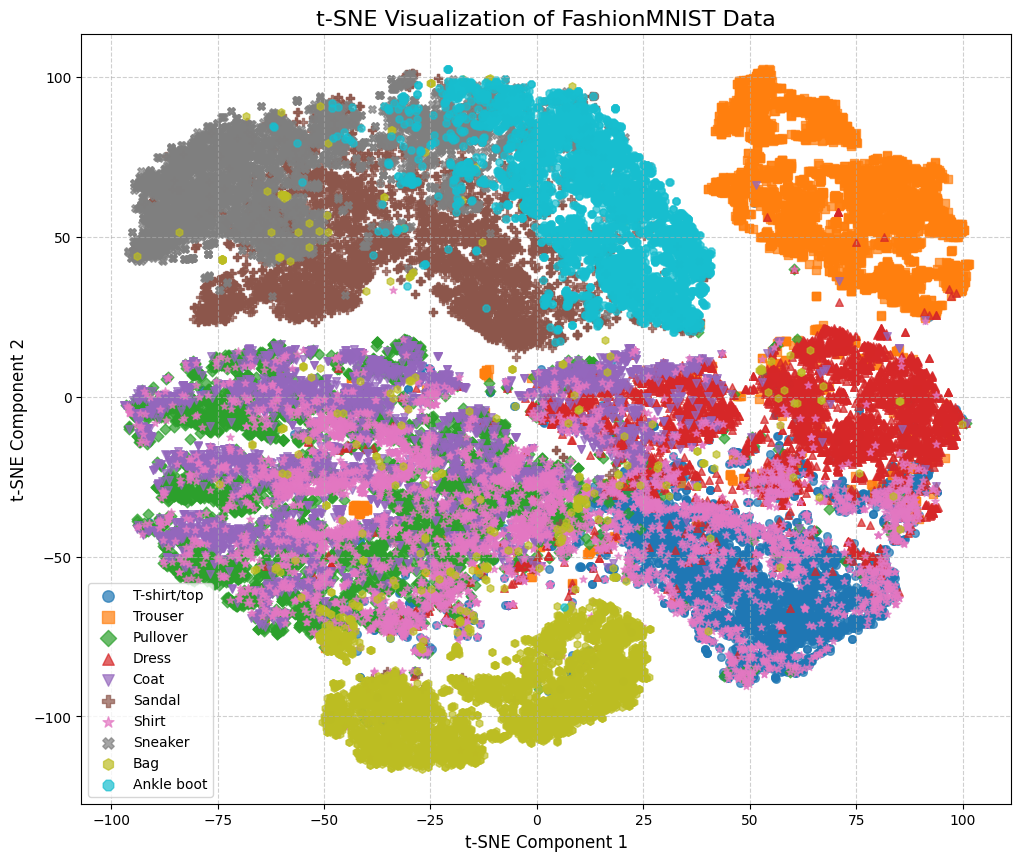

In [ ]:
%matplotlib inline
tsne = TSNE(n_components=2,
            learning_rate= 200,
            n_iter = 2000,
            init='random',
            perplexity=30,
            random_state = 42,
            metric = "euclidean")
X_train_tsne = tsne.fit_transform(X_train_flat)
Class label names for FashionMNIST
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]
# Plot the t-SNE result
plt.figure(figsize=(12, 10))
markers = ['o', 's', 'D', '^', 'v', 'P', '*', 'X', 'h', '8']  # Different markers

for i, class_name in enumerate(class_names):
    indices = y_train == i
    plt.scatter(
        X_train_tsne[indices, 0],
        X_train_tsne[indices, 1],
        label=class_name,
        s=30,
        alpha=0.7,
        marker=markers[i]
    )

plt.title("t-SNE Visualization of FashionMNIST Data", fontsize=16)
plt.xlabel("t-SNE Component 1", fontsize=12)
plt.ylabel("t-SNE Component 2", fontsize=12)
plt.legend(loc="best", fontsize=10, markerscale=1.5)
plt.grid(True, linestyle="--", alpha=0.6)
plt.savefig("2d_tsne_original")
plt.show()

In [ ]:
print("Embedding vectors of t-SNE to 2D on Original Dataset")
print(tsne.embedding_)
print(tsne.embedding_.shape)
print("KL Divergence of t-SNE to 2D on Original Dataset")
print(tsne.kl_divergence_)

Embedding vectors of t-SNE to 2D on Original Dataset
[[-42.792397  -15.090147 ]
 [ 72.19952   -67.809395 ]
 [ 78.21882   -11.785055 ]
 ...
 [-43.752823    2.7973886]
 [  6.5868444  77.614914 ]
 [ 83.31811    69.76765  ]]
(48000, 2)
KL Divergence of t-SNE to 2D on Original Dataset
2.343935012817383


In [ ]:
# Apply t-SNE to all training data with 3 components
tsne = TSNE(n_components=3,
            learning_rate= 200,
            n_iter = 2000,
            init='random',
            perplexity=30,
            random_state = 42,
            metric = "euclidean")
X_train_tsne_3D = tsne.fit_transform(X_train_flat)

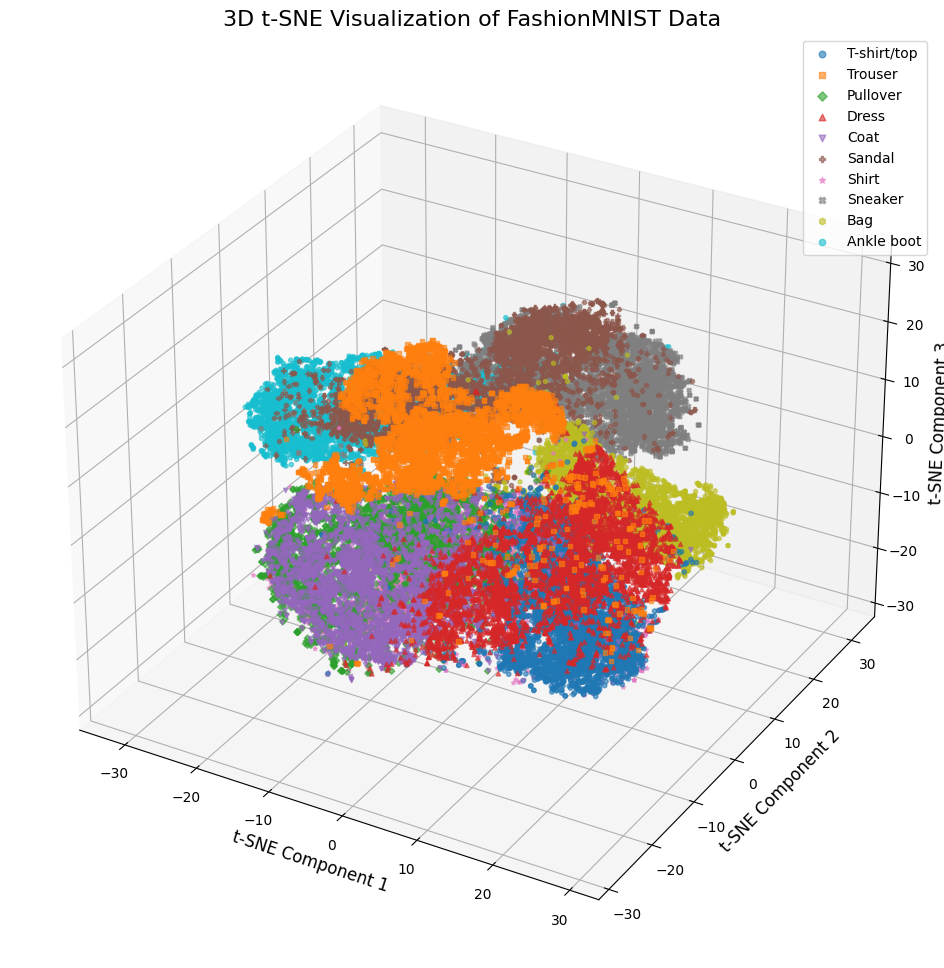

In [ ]:
%matplotlib inline
# Plot the t-SNE result in 3D
fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111, projection='3d')

markers = ['o', 's', 'D', '^', 'v', 'P', '*', 'X', 'h', '8']  # Different markers

for i, class_name in enumerate(class_names):
    indices = y_train == i
    ax.scatter(
        X_train_tsne_3D[indices, 0],
        X_train_tsne_3D[indices, 1],
        X_train_tsne_3D[indices, 2],
        label=class_name,
        s=10,
        alpha=0.6,
        marker=markers[i]
    )

ax.set_title("3D t-SNE Visualization of FashionMNIST Data", fontsize=16)
ax.set_xlabel("t-SNE Component 1", fontsize=12)
ax.set_ylabel("t-SNE Component 2", fontsize=12)
ax.set_zlabel("t-SNE Component 3", fontsize=12)
ax.legend(loc="best", fontsize=10, markerscale=1.5)
plt.savefig("3d_tsne_original")
plt.show()

## PCA then t-SNE

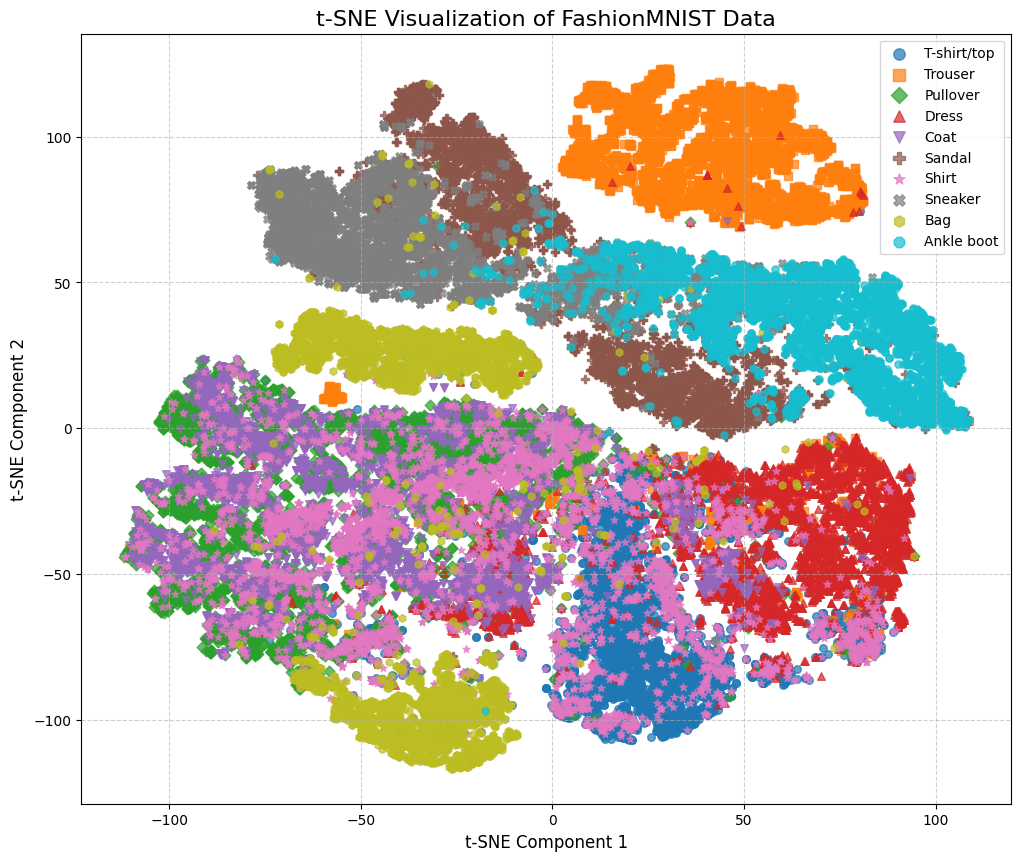

In [ ]:
tsne = TSNE(n_components=2,
            learning_rate= 200,
            n_iter = 2000,
            init='random',
            perplexity=30,
            random_state = 42,
            metric = "euclidean")
pca = PCA(n_components = 50)
X_train_pca = pca.fit_transform(X_train_flat)
X_tsne_pca = tsne.fit_transform(X_train_pca)

# Plot the t-SNE result
plt.figure(figsize=(12, 10))
markers = ['o', 's', 'D', '^', 'v', 'P', '*', 'X', 'h', '8']  # Different markers

for i, class_name in enumerate(class_names):
    indices = y_train == i
    plt.scatter(
        X_tsne_pca[indices, 0],
        X_tsne_pca[indices, 1],
        label=class_name,
        s=30,
        alpha=0.7,
        marker=markers[i]
    )

plt.title("t-SNE Visualization of FashionMNIST Data", fontsize=16)
plt.xlabel("t-SNE Component 1", fontsize=12)
plt.ylabel("t-SNE Component 2", fontsize=12)
plt.legend(loc="best", fontsize=10, markerscale=1.5)
plt.grid(True, linestyle="--", alpha=0.6)
plt.savefig("2d_tsne_pca")
plt.show()

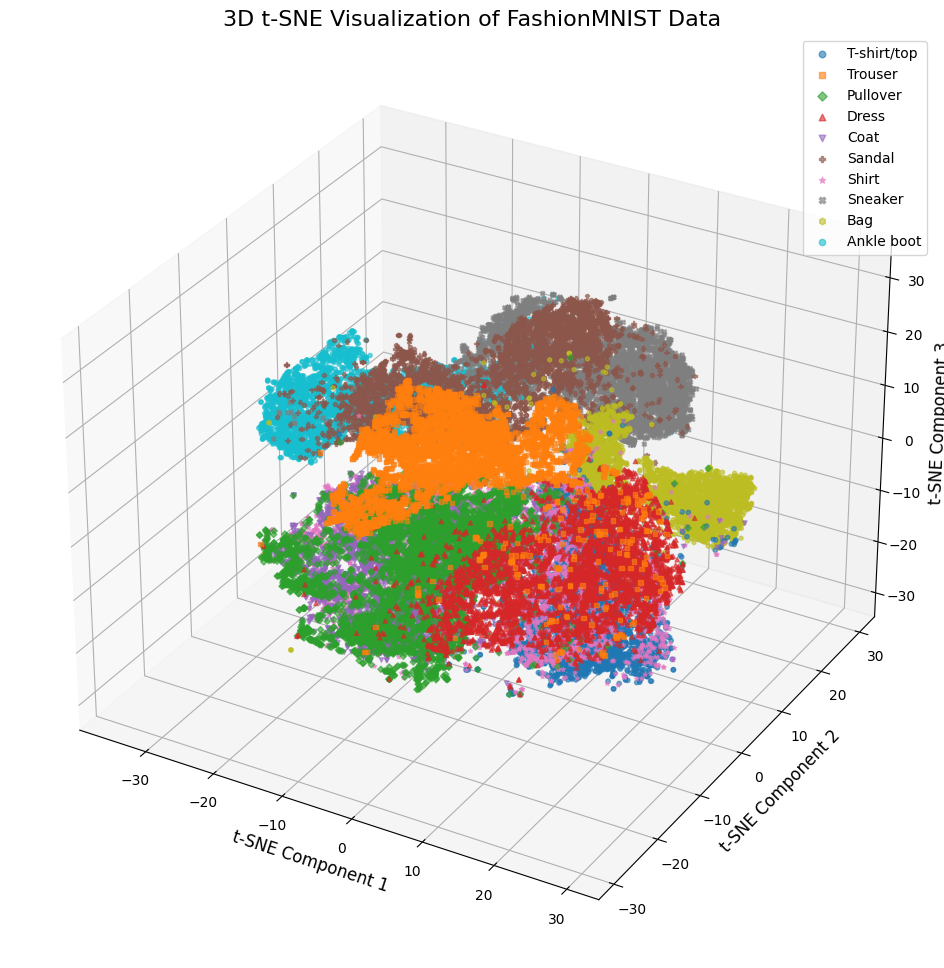

In [ ]:
tsne = TSNE(n_components=3,
            learning_rate= 200,
            n_iter = 2000,
            init='random',
            perplexity=30,
            random_state = 42,
            metric = "euclidean")
pca = PCA(n_components = 50)
X_train_pca = pca.fit_transform(X_train_flat)
X_tsne_pca_3D = tsne.fit_transform(X_train_pca)

fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111, projection='3d')

markers = ['o', 's', 'D', '^', 'v', 'P', '*', 'X', 'h', '8']  # Different markers

for i, class_name in enumerate(class_names):
    indices = y_train == i
    ax.scatter(
        X_tsne_pca_3D[indices, 0],
        X_tsne_pca_3D[indices, 1],
        X_tsne_pca_3D[indices, 2],
        label=class_name,
        s=10,
        alpha=0.6,
        marker=markers[i]
    )

ax.set_title("3D t-SNE Visualization of FashionMNIST Data", fontsize=16)
ax.set_xlabel("t-SNE Component 1", fontsize=12)
ax.set_ylabel("t-SNE Component 2", fontsize=12)
ax.set_zlabel("t-SNE Component 3", fontsize=12)
ax.legend(loc="best", fontsize=10, markerscale=1.5)
plt.savefig("3d_tsne_pca")
plt.show()

# CNN

## Checking value range

In [ ]:
print(X_train.min(), X_train.max())
print(X_valid.min(), X_valid.max())
print(X_test.min(), X_test.max())

X_train = X_train.astype('float32') / 255.0
X_valid = X_valid.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

print('---------------------------')

print(X_train.min(), X_train.max())
print(X_valid.min(), X_valid.max())
print(X_test.min(), X_test.max())

0 255
0 255
0 255
---------------------------
0.0 1.0
0.0 1.0
0.0 1.0


## Input data

In [ ]:
# Image size
img_size = 28

# Rescaling the pixel values
train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

# Train data generator
train_generator = train_datagen.flow(
    X_train.reshape(-1, img_size, img_size, 1),  # Reshape for channels
    y_train,
    batch_size=128,
    seed=42,
    shuffle = True
)

# Validation data generator
validation_generator = val_datagen.flow(
    X_valid.reshape(-1, img_size, img_size, 1),
    y_valid,
    batch_size=128,
    shuffle = False
)

# Test data generator
test_generator = test_datagen.flow(
    X_test.reshape(-1, img_size, img_size, 1),
    y_test,
    batch_size=128,
    shuffle = False
)

## CNN model

In [ ]:
img_size = 28
def getModel():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation("relu"))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation("relu"))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation("relu"))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))


    model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), strides=1, padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation("relu"))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(512, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    model.build(input_shape=(None, img_size, img_size, 1))  # 'None' for batch size
    model.compile(optimizer = tf.keras.optimizers.Adam(),
             loss = tf.keras.losses.SparseCategoricalCrossentropy(),
             metrics = [tf.keras.metrics.SparseCategoricalAccuracy])
    return model

In [ ]:
model = getModel()
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 13,018,026 (49.66 MB)

 Trainable params: 13,016,234 (49.65 MB)

 Non-trainable params: 1,792 (7.00 KB)

## Training process

In [ ]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)
history = model.fit(
    train_generator,
    epochs=40,
    validation_data=validation_generator
    ,callbacks=[reduce_lr]
)

Epoch 1/40
375/375 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - loss: 0.8543 - sparse_categorical_accuracy: 0.7138 - val_loss: 1.7425 - val_sparse_categorical_accuracy: 0.4908 - learning_rate: 0.0010
Epoch 2/40
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.3919 - sparse_categorical_accuracy: 0.8606 - val_loss: 0.3180 - val_sparse_categorical_accuracy: 0.8864 - learning_rate: 9.0000e-04
Epoch 3/40
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.3172 - sparse_categorical_accuracy: 0.8846 - val_loss: 0.2542 - val_sparse_categorical_accuracy: 0.9092 - learning_rate: 8.1000e-04
Epoch 4/40
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.2913 - sparse_categorical_accuracy: 0.8961 - val_loss: 0.2808 - val_sparse_categorical_accuracy: 0.9014 - learning_rate: 7.2900e-04
Epoch 5/40
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.2732 - sparse_categorical_accuracy: 0.9036 - val_loss: 0.2544 - val_sparse_categorical_accuracy: 0.9110 - learning_rate: 6.5610e-04
Epoch 6/40
375/375 ━━━━━━━━━

## Training and Validation plot

In [ ]:
import matplotlib.pyplot as plt

def plot_train_val(histogram_summary):
    acc = histogram_summary.history['sparse_categorical_accuracy']
    val_acc = histogram_summary.history['val_sparse_categorical_accuracy']
    loss = histogram_summary.history['loss']
    val_loss = histogram_summary.history['val_loss']
    epochs = range(len(acc))

    # Plot training and validation accuracy per epoch
    plt.figure(figsize=(10, 5))  # Adjust figure size
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)  # Limit y-axis for accuracy
    plt.legend()
    plt.savefig("accuracy_process")

    # Plot training and validation loss per epoch
    plt.figure(figsize=(10, 5))  # Adjust figure size
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0, 3)  # Limit y-axis for loss
    plt.xticks(np.arange(0, 41, 5))  # Set x-axis ticks for loss plot
    plt.legend()
    plt.savefig("loss_process")

    plt.show()

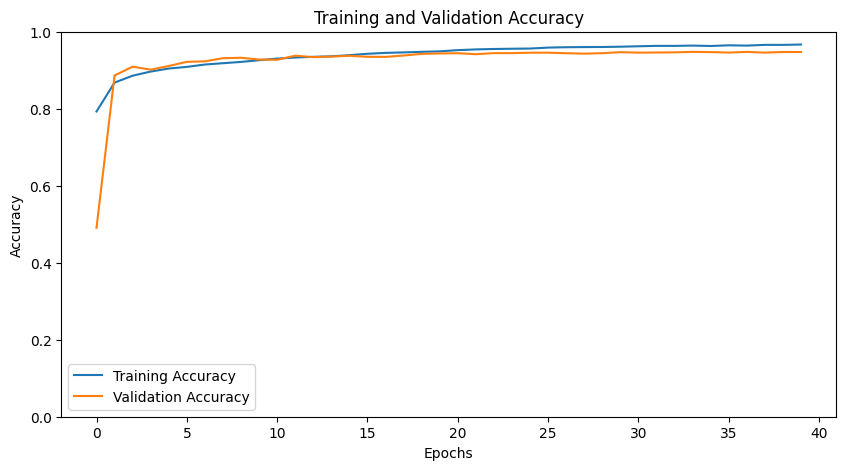

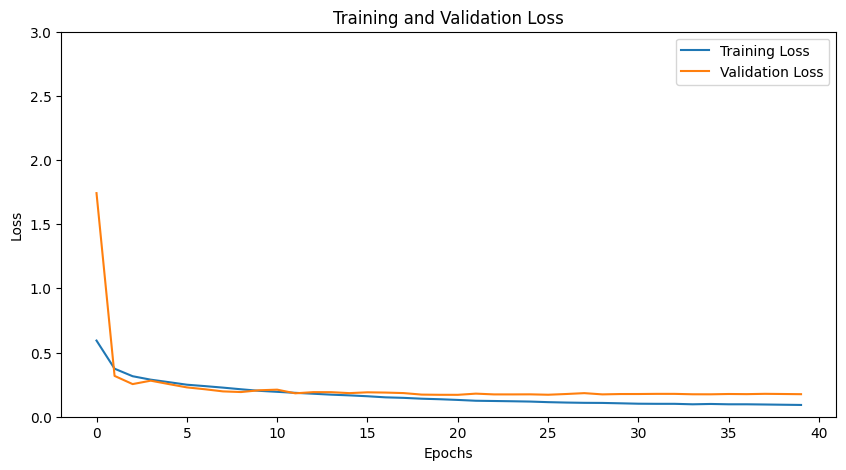

In [ ]:
plot_train_val(history)

In [ ]:
model.evaluate(test_generator)

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.2134 - sparse_categorical_accuracy: 0.9374


[0.20963293313980103, 0.9383000135421753]

## Evaluating the test set

In [ ]:
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]
pred = model.predict(test_generator)

y_pred = np.argmax(pred, axis = 1)

print("Confusion Matrix:")

print(confusion_matrix(test_generator.y, y_pred))

print("\nClassification Report:")

print(classification_report(test_generator.y, y_pred, target_names = class_names))

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Confusion Matrix:
[[896   0  20  10   2   1  69   0   2   0]
 [  0 990   0   7   0   0   1   0   2   0]
 [ 18   1 941   7  18   0  15   0   0   0]
 [ 12   0  10 948  20   0  10   0   0   0]
 [  1   0  37  22 922   0  18   0   0   0]
 [  0   0   0   0   0 984   0  12   0   4]
 [ 87   0  61  21  66   0 762   0   3   0]
 [  0   0   0   0   0   2   0 990   0   8]
 [  2   1   1   1   1   1   1   0 992   0]
 [  0   0   0   0   0   4   1  37   0 958]]

Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.88      0.90      0.89      1000
     Trouser       1.00      0.99      0.99      1000
    Pullover       0.88      0.94      0.91      1000
       Dress       0.93      0.95      0.94      1000
        Coat       0.90      0.92      0.91      1000
      Sandal       0.99      0.98      0.99      1000
       Shirt       0.87      0.76      0.81      1000
     Sneaker       0.95      0.99      0.97      1000
 

In [ ]:
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred, average = "weighted"))
print(recall_score(y_test, y_pred, average = "weighted"))

0.9383
0.9382667065326359
0.9383


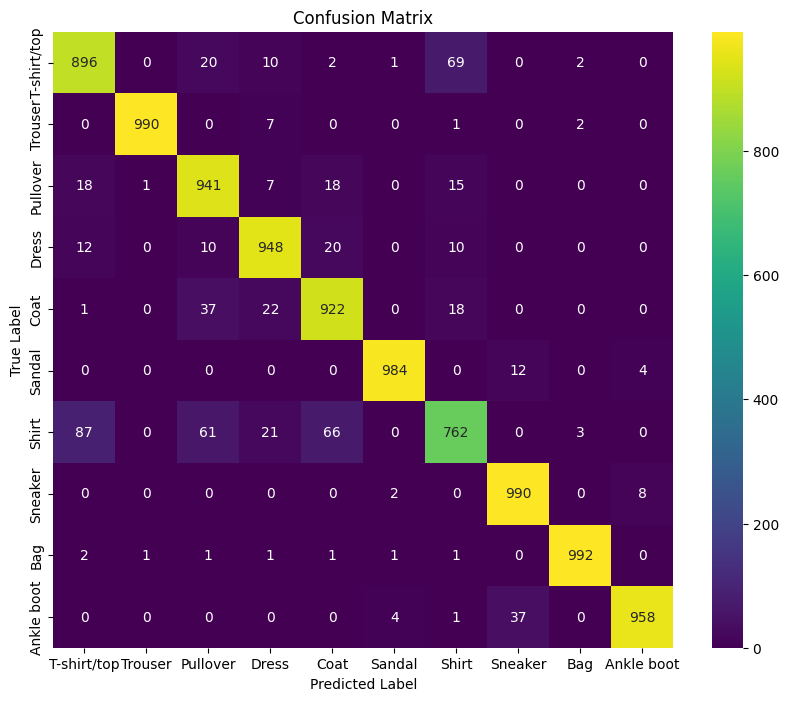

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming y_test contains actual labels and y_pred contains predicted labels
# Replace these variables with your actual test labels and predictions
# y_test: Ground truth labels
# y_pred: Predicted labels by the model

# Define class names
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig("cnn_conf_matrix")
plt.show()